In [1]:
tracePaths = ['C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge/realignment']
jump       = 1000 # unit of number of traces (if jump is 1000, it calculate the correlation of 1000, 2000, 3000, ... traces)
batchSize  = 1000 # related to GPU memory1

# Libararies

In [2]:
import os
import gc
import copy
import cupy as cp
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 12

axisFontSize  = 14
titleFontSize = 20

# CPA

In [3]:
SBox     = np.array([0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79, 0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16], dtype=np.uint8)
InvSBox  = np.array([0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb, 0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb, 0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e, 0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25, 0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92, 0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84, 0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06, 0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b, 0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73, 0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e, 0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b, 0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4, 0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f, 0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef, 0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61, 0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d], dtype=np.uint8)
HW       = np.array([ 0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8 ]).astype(np.float32)
rightKey = np.array([0xa3, 0xad, 0x39, 0x10, 0x4a, 0xa9, 0xe4, 0x48, 0x27, 0x76, 0xe8, 0xb1, 0x03, 0x03, 0xc0, 0x77], dtype=np.uint8)

In [4]:
def get1dCumsum(data, jump):
    return cp.cumsum(cp.sum(data.reshape((-1, jump)), axis=1))

def get2dCumsum(data, jump):
    return cp.cumsum(cp.sum(data.reshape((data.shape[0], -1, jump)), axis=2), axis=1)

def getCumCorr(X, XcumSum, Xdiff, Y, numTrace, jump):
    YcumSum       = get1dCumsum(          Y,  jump)
    YcumSumSquare = get1dCumsum(cp.square(Y), jump)
    squareYcumSum = cp.square(YcumSum)
    Ydiff = cp.sqrt(numTrace * YcumSumSquare - squareYcumSum)
    corrs = (numTrace * get2dCumsum(cp.asarray(X, dtype=np.float32) * Y, jump) - XcumSum * YcumSum) / (Xdiff * Ydiff)
    return np.abs(cp.asnumpy(corrs))

def CPA(trace, cipher, rightKey, resultPath, jump, HW, InvSBox, batchSize): # split by points
    numTrace   = np.arange(jump, trace.shape[0]+1, jump)
    cpNumTrace = cp.asarray(numTrace)
    trace  = trace[:numTrace[-1]]
    cipher = cipher[:numTrace[-1]]
    
    HW      = cp.asarray(HW,      dtype=cp.float32)
    cipher  = cp.asarray(cipher,  dtype=cp.uint8)
    InvSBox = cp.asarray(InvSBox, dtype=cp.uint8)
    
    rightCorrs = np.zeros((16, trace.shape[1]))
    maxCorrs   = np.zeros((16, 256, len(numTrace)))
    for batchIndex in tqdm(range(int(np.ceil(trace.shape[1] / batchSize)))):
        sp = batchIndex*batchSize
        ep = (batchIndex+1)*batchSize
        currentTrace = cp.asarray(trace[:, sp:ep].transpose(), dtype=cp.float32)
        
        traceCumSum       = get2dCumsum(          currentTrace,  jump)
        traceCumSumSquare = get2dCumsum(np.square(currentTrace), jump)
        squareTraceCumSum = cp.square(traceCumSum)
        traceDiff = cp.sqrt(cpNumTrace * traceCumSumSquare - squareTraceCumSum)
        del traceCumSumSquare, squareTraceCumSum
        gc.collect()
    
        for targetByte in tqdm(range(16), leave=False):
            for guessKey in range(256):
                hypoPower = HW[InvSBox[cipher[:, targetByte] ^ guessKey]]
                corrs = getCumCorr(currentTrace, traceCumSum, traceDiff, hypoPower, cpNumTrace, jump)
                if guessKey == rightKey[targetByte]:
                    rightCorrs[targetByte, sp:ep] = corrs[:, -1]
                
                maxCorr = np.max(np.abs(corrs), axis=0)
                lowerIndex = maxCorrs[targetByte, guessKey] < maxCorr
                maxCorrs[targetByte, guessKey, lowerIndex] = maxCorr[lowerIndex]
                
    np.save('{}/rightCorrs.npy'.format(resultPath), rightCorrs)
    np.save('{}/maxCorrs.npy'.format(resultPath),   maxCorrs)


# Draw result

In [5]:
def drawCorrs(resultPath, rightKey, dataNum):
    maxCorrs = np.load('{}\\maxCorrs.npy'.format(resultPath))

    fig, axes = plt.subplots(4, 4, figsize=(9, 7))
    axes = axes.flat
    xtickUnit = 10000
    xtickJump = 10
    x = np.arange(jump, dataNum+1, jump)
    for byteIndex in range(16):
        axes[byteIndex].plot(x, maxCorrs[byteIndex].T, color='k', linewidth=0.5)
        axes[byteIndex].plot(x, maxCorrs[byteIndex, (rightKey[byteIndex]+1)%256], color='k', label='Wrong key')
        axes[byteIndex].plot(x, maxCorrs[byteIndex, rightKey[byteIndex]], color='r', label='Right key')
        axes[byteIndex].set_xlim(x[0], x[-1])
        axes[byteIndex].set_ylim(0, 0.06)
        axes[byteIndex].set_xticks(np.arange(xtickJump*xtickUnit, dataNum, xtickJump*xtickUnit), np.arange(xtickJump, dataNum / xtickUnit, xtickJump).astype(np.int32))
        axes[byteIndex].set_title('{} byte'.format(byteIndex), fontsize=axisFontSize)
    axes[-1].legend(fontsize=axisFontSize, loc=(1.05, 0))
    fig.text(0.42, 0, 'Number of traces ($\\times${})'.format(xtickUnit), ha='center', va='center', fontsize=titleFontSize)
    fig.text(0, 0.500, 'Correlation coefficient', ha='center', va='center', rotation='vertical', fontsize=titleFontSize)
    fig.tight_layout()
    fig.savefig('{}\\corrs.png'.format(resultPath), dpi=300)
    plt.show()

In [6]:
def drawMTD(resultPath, rightKey, jump):
    maxCorrs = np.load('{}\\maxCorrs.npy'.format(resultPath))
    
    MTD = np.zeros(16)
    for byteIndex in range(16):
        keys = np.argmax(maxCorrs[byteIndex], axis=0)
        failIndex = np.where(keys != rightKey[byteIndex])[0]
        if failIndex[-1] != len(keys) - 1:
            MTD[byteIndex] = np.max(failIndex) + 1
    MTD *= jump
    print(MTD)
    print(np.max(MTD))
        
    plt.figure(figsize=(5, 5))
    plt.bar(np.arange(16, dtype=np.uint32), MTD)
    plt.xticks(np.arange(16, dtype=np.uint32), np.arange(16, dtype=np.uint32))
    plt.xlabel('Target Byte', fontsize=axisFontSize)
    plt.ylabel('Minimum number of Traces to Disclosure', fontsize=axisFontSize)
    plt.tight_layout()
    plt.ylim(0, len(keys) * jump)
    plt.ylim(0, 50000)
    plt.savefig('{}\\MTD_{}.png'.format(resultPath, max(MTD)), dpi=300)
    plt.show()    

In [7]:
def drawRightCorr(resultFolderName, trace):
    rightCorrs = np.load('{}\\rightCorrs.npy'.format(resultFolderName))
    
    plt.figure(figsize=(9, 6))
    
    plt.subplot(2, 1, 1)
    plt.title('Trace', fontsize=titleFontSize)
    plt.plot(trace[:400].T, color='k', linewidth=0.3, alpha=0.1)
    plt.plot(trace[:4].T, color='k', linewidth=0.3, alpha=0.1)
    plt.xlim(0, len(trace[0]))
    plt.ylabel('Voltage', fontsize=axisFontSize)
    
    plt.subplot(2, 1, 2)
    plt.title('Correlation', fontsize=titleFontSize)
        
    colors = plt.cm.Set1(np.linspace(0.1, 0.9, 9))[:4]
    colors = np.concatenate((colors, plt.cm.Set1(np.linspace(0.1, 0.9, 8))[5:8]))
    colors = np.concatenate((colors, plt.cm.Dark2(np.linspace(0.1, 0.9, 8))[:7]))
    colors = np.concatenate((colors, plt.cm.Set2(np.linspace(0.1, 0.9, 8))[:7]))
    maxCorr = 0
    for byteIndex in range(16):
        plt.plot(rightCorrs[byteIndex], color=colors[byteIndex], label='{}'.format(byteIndex))
        if maxCorr < np.max(rightCorrs[byteIndex]):
            maxCorr = np.max(rightCorrs[byteIndex])
        
    plt.xlabel('Time',                             fontsize=axisFontSize)
    plt.ylabel('Absolute Correlation', fontsize=axisFontSize)
    plt.xlim(0, len(trace[0]))
    plt.ylim(0, 1.2*maxCorr)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(ncol=8, loc=(0, -0.7))
    
    plt.tight_layout()
    plt.savefig('{}/rightCorr.png'.format(resultFolderName), dpi=300, bbox_inches='tight')
    plt.show()


In [8]:
def drawRatio(resultPath, rightKey):
    maxCorrs = np.load('{}\\maxCorrs.npy'.format(resultPath))
    
    rightCorrs = np.empty(16)
    ratios     = np.empty(16)
    for byteIndex in range(16):
        lastCorr = maxCorrs[byteIndex, :, -1]
        rightCorrs[byteIndex] = lastCorr[rightKey[byteIndex]]
        ratios[byteIndex] = rightCorrs[byteIndex] / np.max(np.concatenate((lastCorr[:rightKey[byteIndex]], lastCorr[rightKey[byteIndex]+1:])))

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(16), rightCorrs)
    plt.title('Correlation of the right key', fontsize=titleFontSize)
    plt.xlabel('Byte', fontsize=axisFontSize)
    plt.xticks(np.arange(16, dtype=np.uint32), np.arange(16, dtype=np.uint32))
    
    plt.subplot(1, 2, 2)
    plt.bar(range(16), ratios)
    plt.xticks(np.arange(16, dtype=np.uint32), np.arange(16, dtype=np.uint32))
    plt.hlines(1, 0, 15, color='r')
    plt.title('Ratio', fontsize=titleFontSize)
    plt.xlabel('Byte', fontsize=axisFontSize)
    
    plt.tight_layout()
    plt.savefig('{}/corr_ratio.png'.format(resultFolderName), dpi=300, bbox_inches='tight')
    plt.show()

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(141687, 10800)


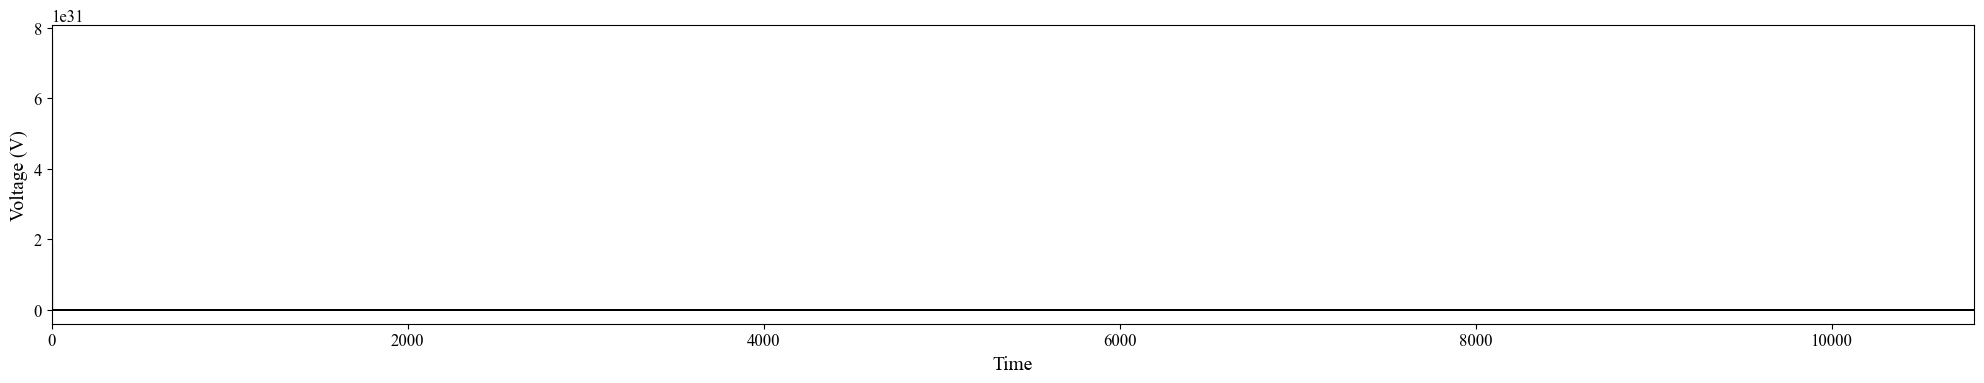


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

  6%|█████▏                                                                             | 1/16 [00:01<00:25,  1.67s/it]

 12%|██████████▍                                                                        | 2/16 [00:03<00:21,  1.57s/it]

 19%|███████████████▌                                                                   | 3/16 [00:04<00:19,  1.52s/it]

 25%|████████████████████▊                                                              | 4/16 [00:06<00:18,  1.50s/it]

 31%|█████████████████████████▉                                                         | 5/16 [00:07<00:16,  1.49s/it]

 38%|███████████████████████████████▏                                                   | 6/16 [00:09<00:14,  1.48s/it]

 44%|██████████████████████████

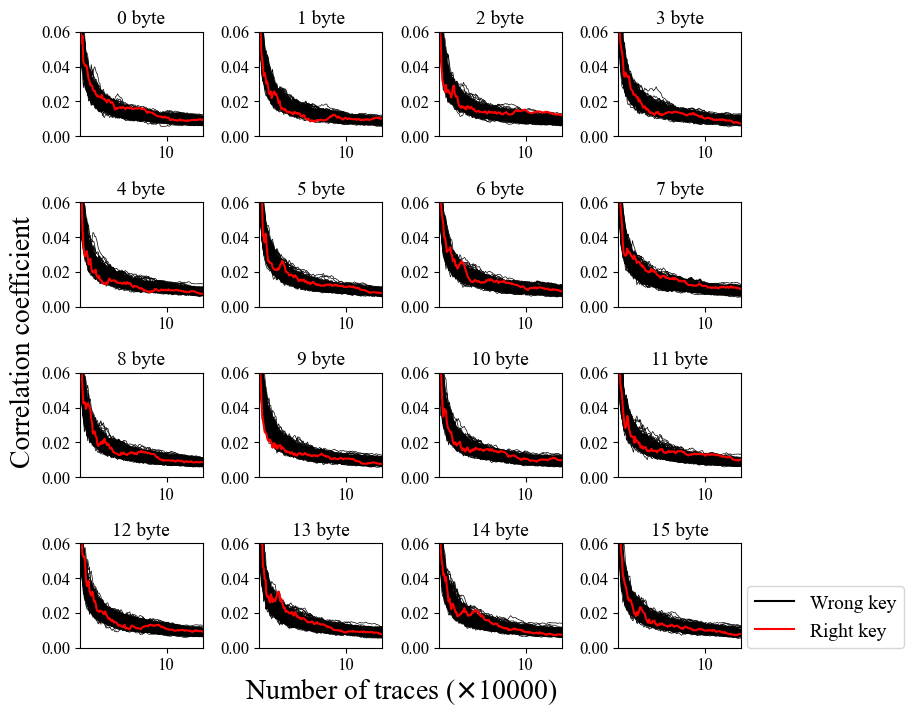

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0


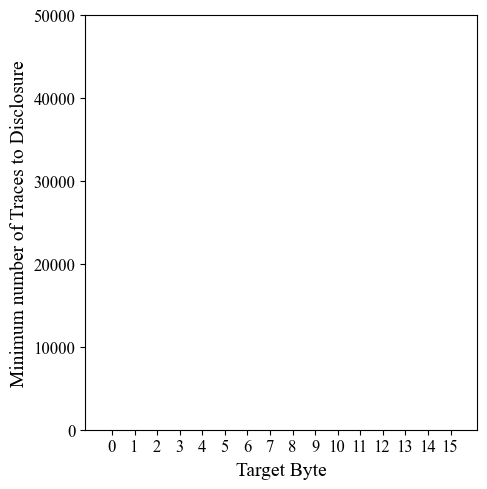

C:\Users\01sun\AppData\Local\Temp\ipykernel_50236\3504464312.py:29: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, 1.2*maxCorr)


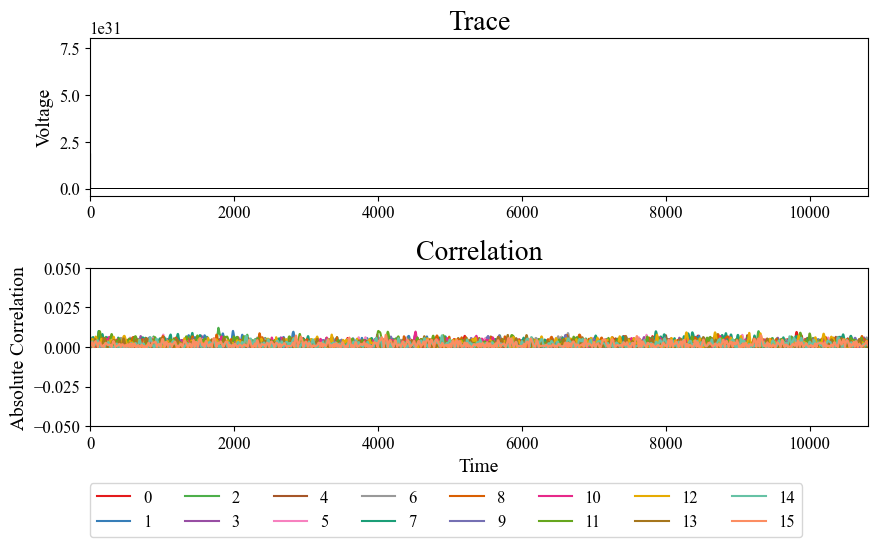

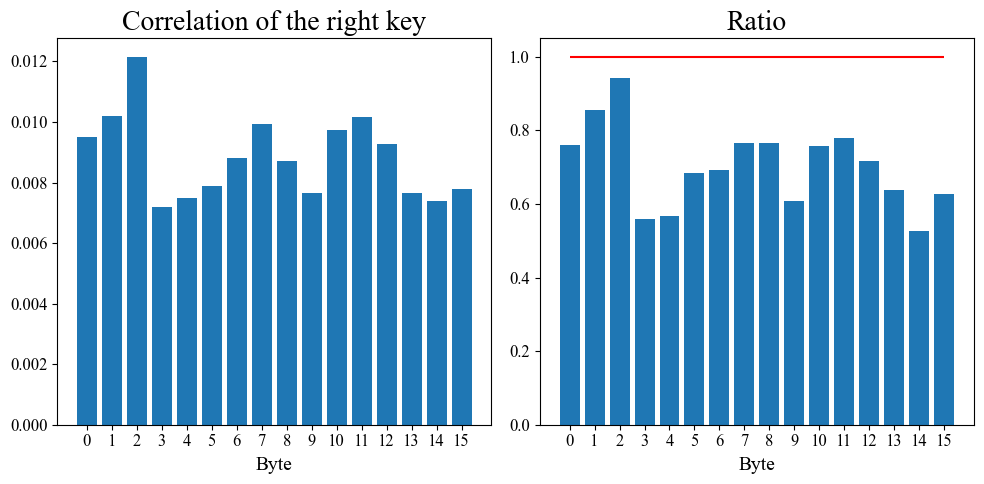

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:37<00:00, 277.13s/it]


In [11]:
import numpy as np
from tqdm import tqdm

# Constants
num_traces = 141687  # Total number of traces
num_points = 10800  # Points per trace

# Define file paths for memory-mapped files
trace_memmap_file = "C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge/realignment/filtered_trace.npy"
cipher_memmap_file = "C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge/realignment/cipher.npy"

# # Create memory-mapped arrays
# trace = np.memmap(trace_memmap_file, dtype=np.float32, mode="w+", shape=(num_traces, num_points))
# cipher = np.memmap(cipher_memmap_file, dtype=np.uint8, mode="w+", shape=(num_traces, 16))

# # Load and combine traces and cipher texts
# for i in tqdm(range(num_traces), desc="Loading traces and ciphers"):
#     trace[i, :] = np.load(f"{tracePaths[0]}/trace_{i}.npy")
#     cipher[i, :] = np.load(f"{tracePaths[0]}/cipher_{i}.npy")

# # Flush data to disk
# trace.flush()
# cipher.flush()

for tracePath in tqdm(tracePaths):
    resultFolderName = '{}/CPA_MTD_GPU'.format(tracePath)
    os.makedirs(resultFolderName, exist_ok=True)
    
    trace = np.memmap(trace_memmap_file, dtype=np.float32, mode="r", shape=(num_traces, num_points))
    cipher = np.memmap(cipher_memmap_file, dtype=np.uint8, mode="r", shape=(num_traces, 16))

    print(trace.shape)
    
    plt.figure(figsize=(20, 4))
    plt.plot(trace[:400].T, color='k', linewidth=0.3, alpha=0.1)
    plt.xlim(0, trace.shape[1])
    plt.ylabel('Voltage (V)', fontsize=axisFontSize)
    plt.xlabel('Time', fontsize=axisFontSize)
    plt.tight_layout()
    plt.savefig('{}/trace_overlap.png'.format(resultFolderName), dpi=300, bbox_inches='tight')
    plt.show()
    CPA(trace, cipher, rightKey, resultFolderName, jump, HW, InvSBox, batchSize)
    drawCorrs(resultFolderName, rightKey, len(trace))
    drawMTD(resultFolderName, rightKey, jump)
    
    drawRightCorr(resultFolderName, trace)
    drawRatio(resultFolderName, rightKey)